<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Modeling-Systemic-Inflammation-in-Burn-Patients" data-toc-modified-id="Modeling-Systemic-Inflammation-in-Burn-Patients-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Modeling Systemic Inflammation in Burn Patients</a></span><ul class="toc-item"><li><span><a href="#Import-Libraries" data-toc-modified-id="Import-Libraries-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Import Libraries</a></span></li><li><span><a href="#HIIS-Complement-Model" data-toc-modified-id="HIIS-Complement-Model-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>HIIS-Complement Model</a></span></li><li><span><a href="#Cytokines" data-toc-modified-id="Cytokines-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Cytokines</a></span><ul class="toc-item"><li><span><a href="#IL6" data-toc-modified-id="IL6-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>IL6</a></span></li><li><span><a href="#IL10" data-toc-modified-id="IL10-1.3.2"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>IL10</a></span></li></ul></li><li><span><a href="#Plot" data-toc-modified-id="Plot-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Plot</a></span></li><li><span><a href="#Change-Parameters" data-toc-modified-id="Change-Parameters-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Change Parameters</a></span></li><li><span><a href="#Run-Model" data-toc-modified-id="Run-Model-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Run Model</a></span></li></ul></li></ul></div>

In [1]:
__author__ = "Louella Alva Presbitero"

"""
Code to model the innate immune response coupled with the Alkaline Phosphatase simulator.
Created on Thu Mar 10 11:24:36 2016. Runtime is in minutes.
"""

import seaborn as sns

sns.set_palette("deep")
sns.set_color_codes("deep")

# Modeling Systemic Inflammation in Burn Patients

Eplore how heat affects the human innate immune system.

## Import Libraries

In [2]:
import sys
sys.path.append('../')

import burn

In [3]:
from burn.preprocess import *
from burn.model import *
from burn.utils import *
from burn.plot import *
from burn.parameters import *

In [4]:
numpoints

10000

In [5]:
import burn.preprocess.cytokines as cyto
import burn.preprocess.blood_params as dp

In [6]:
from scipy.interpolate import interp1d

import numpy as np
import scipy as s
import csv as c
import seaborn as sns
import pandas as pd
import os
import scipy.integrate as spi
import matplotlib.pyplot as plt

## HIIS-Complement Model

In [7]:
def vectorfield(w, t, p, params):
    """
    Define differential equations for the innate immune system.

    Arguments:
        w : vector of the state variables
            w=[N_R, AP_Eblood, AP_Etissue, AP_Eliver, AP_Sblood, AP_Stissue, ITMblood, ITMtissue, M_R, M_A, CH,
            N_A, ND_A, ACH, ND_N]
        t : time
        p : vector of the parameters
    """

    N_R, AP_Eblood, AP_Etissue, AP_Eliver, AP_Sblood, AP_Stissue, ITMblood, ITMtissue, M_R, M_A, CH, N_A, ND_A, \
        ACH, ND_N, C_blood, C, C_A, C_B, TGF_beta = pre_vectorfield(w, params)

    mu_ACH, mu_APE, mu_APS, mu_APSfast, mu_APSslow, mu_CH, mu_MA, mu_MR, mu_NA, mu_NDA, mu_NDN, mu_NR, mu_ITM, \
        Pmin_MR, Pmin_NR, ACHmax, CHmax_tissue, Mmax, Nmax, Pmax_MR, Pmax_NR, Keq_CH, phi_MRA, \
        theta_ACH, lamb_APE, lamb_ITMNA, lamb_ITMMA, lamb_MANDA, lamb_MANDN, lamb_APS, alpha_ACHMA, \
        beta_CHMA, beta_CHNA, beta_MANDA, APEmax, APEbmax, APElmax, APSmax, rdistress, lamb_ITMNDN, alpha_ITMNDN, \
        Pmax_APE, Pmin_APE, rinduce_peak, AP_Sinj, w_gauss_min, r_Nhomeo, r_APhomeo, Pmax_ITM, Pmin_ITM, ITMmax, \
        step_max, r_NDN, r_ITM, ITMblood_peak, r_AP, rinduce, ITM_source_peak, ITM_source_width, mu_C, mu_TFGbeta, \
        alpha_CAMA, alpha_CBMA, alpha_TFGbetaMA, TGF_betamax, Keq_CHC, Cmax, Pmax_C, Pmin_C, r_Chomeo, C_bloodmax, r_c, C_lambmin, theta_TGFbeta = p

    hypothesis = 0
    CH_delay = 20
    NDA_delay = 5. * 60.
#     delay_AP = 60.
    # no delay
    delay_AP = 0

    f_dillution = 1. / \
        16.  # (80/5) ratio betweenblood tissue compartment and blood compartment

    t_ITM = 10.
#     t_ITM_source = 5. * 60.
    t_inject = 8. * 60.

    if params['h'] == 'h4':
        hypothesis = (rinduce_peak / (1 + np.exp(rinduce *
                      (t - delay_AP)))) * (AP_Sblood + AP_Stissue)

    hypothesis *= int(not (hypothesis < 0))

#     if params['restrict']:
    source_ITM = ITM_source_peak * \
        np.exp(-(1. / (2. * (ITM_source_width ** 2)))
               * (t - t_ITM_source) ** 2)
#     else:
#         source_ITM = 0
        
    k = (CH + C_A) / (CH + C_A + Keq_CHC)
    
    f = [
        # N_R
        (
        - mu_NR * N_R
        - (Pmax_NR * k * (1 - N_A / Nmax) * N_R)
        + r_Nhomeo * (1. - N_R / Nmax) * N_R
        ) * int(not (N_R < 0))
        ,

        # AP_Eblood
        - mu_APE * AP_Eblood
        - lamb_APE * AP_Eblood * ITMblood
        - ((Pmax_APE - Pmin_APE) * k + Pmin_APE) * AP_Eblood
        + rdistress * AP_Eblood * (1 - AP_Eblood/APEbmax),
#         + (1. / (1. + np.exp(- r_AP * (t - delay_AP)))) *
#         (hypothesis + rdistress * np.exp(-(1. / (2. * (w_gauss_min ** 2)))
#          * (AP_Eblood + AP_Sblood) ** 2)),

        # AP_Etissue
        - mu_APE * AP_Etissue
        - lamb_APE * AP_Etissue * ITMtissue
        + f_dillution * ((Pmax_APE - Pmin_APE) * k + Pmin_APE) * AP_Eblood,

        # AP_Eliver
        (1. / (1. + np.exp(- r_AP * (t - delay_AP)))) *
        (hypothesis + rdistress * np.exp(-(1. / (2. * (w_gauss_min ** 2)))
         * (AP_Eblood + AP_Sblood) ** 2)),

        # AP_Sblood
        (- mu_APS * AP_Sblood
         - lamb_APS * AP_Sblood * ITMblood
         + AP_Sinj * (1. / (1. + np.exp((step_max * (t - t_inject)))))
         - ((Pmax_APE - Pmin_APE) * k + Pmin_APE) * AP_Sblood)
        * (int(not (AP_Sblood < 0))),

        # AP_Stissue
        - mu_APS * AP_Stissue
        - lamb_APS * AP_Stissue * ITMtissue
        + f_dillution * ((Pmax_APE - Pmin_APE) * \
                         k + Pmin_APE) * AP_Sblood,

        # ITMblood
        (- mu_ITM * ITMblood
         - ITMblood * (lamb_APE * AP_Eblood + lamb_APS * AP_Sblood)
         - ((Pmax_ITM - Pmin_ITM) * k + Pmin_ITM) * ITMblood * (1 - ITMtissue / ITMmax))
        * (int(not (ITMblood < 0)))
#         + ITMblood_peak * (1 - ITMblood / ITMmax) * \
#         (1. / (1. + np.exp(r_ITM * (t - t_ITM))))
        + ITM_source_peak * np.exp(-(1. / (2. * (ITM_source_width ** 2)))
               * (t - t_ITM_source) ** 2)
        ,

        # ITMtissue
        (- mu_ITM * ITMtissue
         - ITMtissue * (
             lamb_APE * AP_Etissue
             + lamb_APS * AP_Stissue
             + (1 / (1 + np.exp(-r_c*((C_B - C_lambmin)/C_bloodmax)))) * \
             lamb_ITMMA * M_A
             + lamb_ITMNDN * N_A)
         + alpha_ITMNDN * ND_N/(1 + (theta_TGFbeta * TGF_beta))
         + f_dillution * ((Pmax_ITM - Pmin_ITM) * k + Pmin_ITM) * ITMblood
         * (1. - ITMtissue / ITMmax)) * (int(not (ITMtissue < 0))),

        # M_R
        - mu_MR * M_R 
        - (phi_MRA * M_R * ITMtissue / (1 + theta_ACH * ACH))
        + (((Pmax_MR - Pmin_MR) * k + Pmin_MR)* (Mmax - (M_A + M_R))),

        # M_A
        - mu_MA * M_A + (phi_MRA * M_R * ITMtissue) / (1 + theta_ACH * ACH),

        # CH
#         (1. / (1. + np.exp(- step_max * (t - CH_delay)))) *
        -mu_CH * CH
         + ((beta_CHNA * N_A * ITMtissue + beta_CHMA * M_A * ITMtissue) * (1 - CH / CHmax_tissue) / (1 + theta_ACH * ACH)),

        # N_A
        - mu_NDA * (N_A / (1 + ITMtissue))
#         - (1. / (1. + np.exp(- r_NDN * (t - NDA_delay)))) * \
        - lamb_ITMNDN * (ITMtissue * N_A)
        + f_dillution * ((Pmax_NR) * k) * \
        (1 - N_A / Nmax) * N_R,

        # ND_A
        mu_NDA * (N_A / (1 + ITMtissue))
        - lamb_MANDA * M_A * ND_A,

        # ACH
        (- mu_ACH * ACH + (alpha_ACHMA * M_A + \
         beta_MANDA * M_A * ND_A) * (1 - ACH / ACHmax)),

        # ND_N
#         (1. / (1. + np.exp(- r_NDN * (t - NDA_delay)))) * (
        lamb_ITMNDN * (ITMtissue * N_A) 
        - lamb_MANDN * M_A * ND_N
#         )
        ,

        # C_blood
        - mu_C * C_blood
        + (r_Chomeo * (1. - C_blood / C_bloodmax)
           * C_blood) * (int(not (C_blood < 0)))
        - ((Pmax_C - Pmin_C) * k + Pmin_C) * C_blood,

        # C
        - (alpha_CAMA * C * ITMtissue) * (1 - C / Cmax)
        - (alpha_CBMA * C * ITMtissue) * (1 - C / Cmax)
        + f_dillution * ((Pmax_C - Pmin_C) * k + Pmin_C) * C_blood,


        # C_A
        - mu_C * C_A
        + (alpha_CAMA * C * ITMtissue) * (1 - C / Cmax),

        # C_B
        - mu_C * C_B
        + (alpha_CBMA * C * ITMtissue) * (1 - C / Cmax),

        # TGF_beta
        - mu_TFGbeta * TGF_beta
        + (alpha_TFGbetaMA * M_A * ITMtissue) * (1 - TGF_beta / TGF_betamax)
    ]

    return post_vectorfield(f, w, params)

In [8]:
def solve(p, w0, t, params):
    """
    Solves the coupled ordinary differential equations and prints it.

    Arguments:
        p        :  vector of the parameters
        w0       :  vector of the initial conditions
        filename :  name of file to store solution
        t        :  time step
        prnt     :  True/False
    """

    # ODE solver parameters
    abserr = 1.0e-8
    relerr = 1.0e-6
    
    # Create the time samples for the output of the ODE solver.
    wsol = s.integrate.odeint(vectorfield, w0, t,
                              args=(p, params),
                              atol=abserr,
                              rtol=relerr,
                              mxstep=100000)
    return t, wsol

In [9]:
data = '../data/patient_blood_edit.xlsx'
df= pd.read_excel(data)
df_clean = df.drop(['Type'], axis=1)
patients = list(set(df_clean['Patient # PBD']))

params_mw = {
    'IL-10 (42)' : 21 * 10 ** 3,
    'IL-6 (36)' : 21*10**3
}

df_clean = df_clean.replace('OOR >', np.nan)
df_clean = df_clean.replace('OOR <', np.nan)
df_clean['Patient # PBD'].unique()
df_clean = df_clean[~df_clean['Patient # PBD'].isin(['standard', 'V2', 'V4', 'V10', 'V15', 'C1', 'C2'])]


## Cytokines

### IL6

Patient # PBD
100    AxesSubplot(0.125,0.125;0.775x0.755)
102    AxesSubplot(0.125,0.125;0.775x0.755)
103    AxesSubplot(0.125,0.125;0.775x0.755)
105    AxesSubplot(0.125,0.125;0.775x0.755)
107    AxesSubplot(0.125,0.125;0.775x0.755)
110    AxesSubplot(0.125,0.125;0.775x0.755)
91     AxesSubplot(0.125,0.125;0.775x0.755)
94     AxesSubplot(0.125,0.125;0.775x0.755)
95     AxesSubplot(0.125,0.125;0.775x0.755)
96     AxesSubplot(0.125,0.125;0.775x0.755)
98     AxesSubplot(0.125,0.125;0.775x0.755)
99     AxesSubplot(0.125,0.125;0.775x0.755)
Name: IL-6 (36), dtype: object

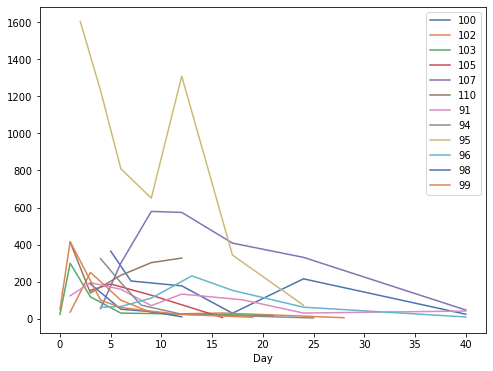

In [10]:
fig, ax = plt.subplots(figsize=(8, 6))
df_ = df_clean[['IL-6 (36)', 'Day', 'Patient # PBD']]
df_.set_index('Day', inplace=True)
df_.groupby('Patient # PBD')['IL-6 (36)'].plot(ax=ax, legend=True)

In [11]:
df_IL6 = cyto.get_med_mad('IL-6 (36)', df_clean, params_mw, to_calculate = ['median', 'mad'])
df_IL6.head()

,median,mad,time
0,1.050777e+06,3.902967e+05,0
1,8.579073e+06,4.092293e+06,24
2,4.598219e+07,0.000000e+00,48
3,4.885517e+06,1.058469e+06,72
4,2.868960e+06,1.004868e+07,96


### IL10

Patient # PBD
100    AxesSubplot(0.125,0.125;0.775x0.755)
102    AxesSubplot(0.125,0.125;0.775x0.755)
103    AxesSubplot(0.125,0.125;0.775x0.755)
105    AxesSubplot(0.125,0.125;0.775x0.755)
107    AxesSubplot(0.125,0.125;0.775x0.755)
110    AxesSubplot(0.125,0.125;0.775x0.755)
91     AxesSubplot(0.125,0.125;0.775x0.755)
94     AxesSubplot(0.125,0.125;0.775x0.755)
95     AxesSubplot(0.125,0.125;0.775x0.755)
96     AxesSubplot(0.125,0.125;0.775x0.755)
98     AxesSubplot(0.125,0.125;0.775x0.755)
99     AxesSubplot(0.125,0.125;0.775x0.755)
Name: IL-10 (42), dtype: object

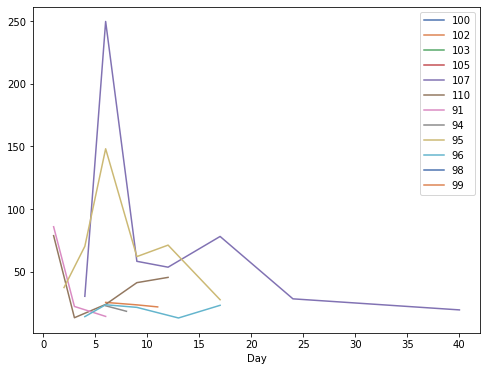

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))
df_ = df_clean[['IL-10 (42)', 'Day', 'Patient # PBD']]
df_.set_index('Day', inplace=True)
df_.groupby('Patient # PBD')['IL-10 (42)'].plot(ax=ax, legend=True)

In [13]:
df_IL10 = cyto.get_med_mad('IL-10 (42)', df_clean, params_mw, to_calculate = ['median', 'mad'])
df_IL10.head()

,median,mad,time
0,NaN,NaN,0
1,2.104133e+06,604400.833333,24
2,1.070987e+06,0.000000,48
3,5.033867e+05,87274.074074,72
4,8.703200e+05,611874.074074,96


## Plot

In [14]:
def plot(df_model, params, df_IL6, df_IL10, t):
    """
    Plots the solution of the coupled ordinary differential equations.
    """

    sns.set_style("ticks")
    sns.set_style({"xtick.direction": "in",
                  "ytick.direction": "in", "axes.linewidth": 2.5})
    
    lw = params['lw']
    ls = params['ls']
    fs = params['fs']
    lfs = params['lfs']
    ts = params['ts']
    ms = params['ms']
    title = params['title']
    timeout = params['timeout']
    case_label = params['case_label']

    if case_label == 'Placebo':
        color = "#377eb8"
    else:
        color = "#4daf4a"

    if case >= 1:
        n = loop_fig(5)
        plt.figure(n)
        plt.plot(t, df_model['N_A'], linewidth=lw,
                 label=case_label, ls='-', color=color)
        plt.xlabel(title, fontsize=fs)
        plt.ylabel("concentration $(cells/mm^3$)", fontsize=fs)
        plt.title("Activated Neutrophils", fontsize=ts)
        plt.legend(loc='best', fontsize=lfs)
        plt.xlim((0,  stoptime / 60.))
        plt.tick_params(labelsize=ls)
        print('... Plotting Activated Neutrophils')
        # plt.savefig('results/plots/' + 'Activated_Neutrophils.png', format='png', dpi=500, bbox_inches='tight')

        n = loop_fig(n)
        plt.figure(n)
        plt.plot(t, df_model['ND_N'], linewidth=lw,
                 label=case_label, ls='-', color=color)
        plt.xlabel(title, fontsize=fs)
        plt.ylabel("concentration $(cells/mm^3$)", fontsize=fs)
        plt.title("Necrotic Neutrophils", fontsize=ts)
        plt.legend(loc='best', fontsize=lfs)
        plt.xlim((0,  stoptime / 60.))
        plt.tick_params(labelsize=ls)
        print('... Plotting Necrotic Neutrophils')
        # plt.savefig('results/plots/' + 'Necrotic_Neutrophils.png', format='png', dpi=500, bbox_inches='tight')

        n = loop_fig(n)
        plt.figure(n)
        plt.plot(t, df_model['ND_A'], linewidth=lw,
                 label=case_label, ls='-', color=color)
        plt.xlabel(title, fontsize=fs)
        plt.ylabel("concentration $(cells/mm^3$)", fontsize=fs)
        plt.title("Apoptotic Neutrophils", fontsize=ts)
#         plt.ylim((0, 25))
        plt.legend(loc='best', fontsize=lfs)
        plt.xlim((0,  stoptime / 60.))
        plt.tick_params(labelsize=ls)

        print('... Plotting Apoptotic Neutrophils')
        # plt.savefig('results/plots/' + 'Apoptotic_Neutrophils.png', format='png', dpi=500, bbox_inches='tight')

        n = loop_fig(n)
        plt.figure(n)
        plt.plot(t, df_model['N_R'], linewidth=lw,
                 label=case_label, ls='-', color=color)
        plt.xlabel(title, fontsize=fs)
        plt.ylabel("concentration $(cells/mm^3$)", fontsize=fs)
#         plt.ylabel("$log_{10}$ Concentration $(cells/mm^3$)", fontsize=fs)
        plt.title("Mature Resting Neutrophils", fontsize=ts)
        plt.tick_params(labelsize=ls)
        plt.legend(loc='best', fontsize=lfs)
        plt.ylim((0, Nmax))
        plt.xlim((0,  stoptime / 60.))
        print('... Plotting Resting Neutrophils')
        # plt.savefig('results/plots/' + 'Resting_Neutrophils.png', format='png', dpi=500, bbox_inches='tight')

        n = loop_fig(n)
        plt.figure(n)
        plt.plot(t, (df_model['M_A']), linewidth=lw,
                 label=case_label, ls='-', color=color)
        plt.xlabel(title, fontsize=fs)
        plt.ylabel("Concentration $(cells/mm^3$)", fontsize=fs)
        plt.title("Activated Macrophages", fontsize=ts)
        plt.legend(loc='best', fontsize=lfs)
        plt.xlim((0,  stoptime / 60.))
        plt.tick_params(labelsize=ls)
        print('... Plotting Activated Macrophages')
        # plt.savefig('results/plots/' + 'Activated_Macrophages.png', format='png', dpi=500, bbox_inches='tight')

        n = loop_fig(n)
        plt.figure(n)
        plt.plot(t, np.log10(df_model['M_R']), linewidth=lw,
                 label=case_label, ls='-', color=color)
        plt.xlabel(title, fontsize=fs)
        plt.ylabel("$log_{10}$ Concentration $(cells/mm^3$)", fontsize=fs)
        plt.title("Resting Macrophages", fontsize=ts)
        plt.legend(loc='best', fontsize=lfs)
        plt.xlim((0,  stoptime / 60.))
        plt.tick_params(labelsize=ls)
        plt.tight_layout()
        print('... Plotting Resting Macrophages')
        # plt.savefig('results/plots/' + 'Resting_Macrophages.png', format='png', dpi=500, bbox_inches='tight')

        n = loop_fig(n)
        plt.figure(n)
        plt.plot(t, (np.log10(df_model['ITMtissue'])),
                 linewidth=lw, label=case_label, ls='-', color=color)
        plt.xlabel(title, fontsize=fs)
        plt.ylabel("$log_{10}$ Concentration $(cells/mm^3$)", fontsize=fs)
        plt.legend(loc='best', fontsize=lfs)
        plt.tick_params(labelsize=ls)
        plt.title("ITM in Tissue", fontsize=ts)
        print('... Plotting ITMs in Tissue')
        # plt.savefig('results/plots/' + 'ITMS_Tissue.png', format='png', dpi=500, bbox_inches='tight')

        n = loop_fig(n)
        plt.figure(n)
        plt.plot(t, (df_model['ITMblood']), linewidth=lw,
                 label=case_label, ls='-', color=color)
        plt.xlabel(title, fontsize=fs)
        plt.ylabel("Concentration $(cells/mm^3$)", fontsize=fs)
        plt.legend(loc='best', fontsize=lfs)
        plt.xlim((0,  stoptime / 60.))
        plt.tick_params(labelsize=ls)
        plt.title("Plasma ITM", fontsize=ts)
        print('... Plotting ITMs in Plasma')
        # plt.savefig('results/plots/' + 'ITMS_Plasma.png', format='png', dpi=500, bbox_inches='tight')

    if case >= 2:
        if case_label != 'bIAP':
            plt.figure(0)
            plt.plot(df_model['Time'], df_model['CH'],
                     linewidth=lw, label="Model", ls='-', color="#377eb8")
#             if case_label == 'Placebo':
#                 plt.errorbar(x=list(df_CH_plc['time']), y=list(df_CH_plc['median']), yerr=list(df_CH_plc['mad']),
#                                  alpha=.5, marker='o', color='#e41a1c', label='Data Median', ms=15)
#             plt.plot(df_IL6['Time'], df_IL6['IL-6 (36)'], alpha=.5,
#                      marker='o', color='#e41a1c', label='Data Median', ms=ms)
    
            plt.errorbar(list(df_IL6['time']), list(df_IL6['median']), yerr = list(df_IL6['mad']),
                                 alpha=.5, linewidth=1.5, marker='o',color='#e41a1c', label='Data Median', ms=ms)

            plt.xlim((0, stoptime/60.))
            plt.ylim((0, 5 * 10 ** 7))
            plt.xlabel(title, fontsize=fs)
            plt.ylabel("concentration $(cells/mm^3$)", fontsize=fs)
            plt.title("Pro-Inflammatory Cytokines", fontsize=ts)
            plt.tick_params(labelsize=ls)
            plt.legend(loc='best', fontsize=lfs)
            plt.xlim((0,  stoptime / 60.))
            print('... Plotting Data for IL6')
            # plt.savefig('results/plots/' + 'Placebo_IL6.png', format='png', dpi=500, bbox_inches='tight')

            plt.figure(1)
            plt.plot(df_model['Time'], df_model['ACH'],
                     linewidth=lw, label="Model", ls='-', color="#377eb8")
#             if case_label == 'Placebo':
#                 plt.errorbar(list(df_ACH_plc['time']), list(df_ACH_plc['median']), yerr = list(df_ACH_plc['mad']),
#                                  alpha=.5, linewidth=1.5, marker='o',color='#e41a1c', label='Data Median', ms=15)

#             plt.plot(df_IL10['Time'], df_IL10['IL-10 (42)'], alpha=.5,
#                      marker='o', color='#e41a1c', label='Data Median', ms=ms)
        
            plt.errorbar(list(df_IL10['time']), list(df_IL10['median']), yerr = list(df_IL10['mad']),
                                 alpha=.5, linewidth=1.5, marker='o',color='#e41a1c', label='Data Median', ms=ms)

            plt.xlim((0,  stoptime/60.))
            plt.ylim((0, 5 * 10 ** 7))
            plt.xlabel(title, fontsize=fs)
            plt.ylabel("concentration $(cells/mm^3$)", fontsize=fs)
            plt.title("Anti-Inflammatory Cytokines", fontsize=ts)
            plt.legend(loc='best', fontsize=15)
            plt.tick_params(labelsize=ls)
            plt.legend(fontsize=lfs)
            print('... Plotting Data for IL10')
            # plt.savefig('results/plots/' + 'Placebo_IL10.png', format='png', dpi=500, bbox_inches='tight')

        if case_label != 'Placebo':
            plt.figure(3)
            plt.plot(df_model['Time'], df_model['CH'],
                     linewidth=lw, label="Model", ls='-', color="#377eb8")
#             if case_label == 'bIAP':
#                 plt.errorbar(x=list(df_CH_biap['time']), y=list(df_CH_biap['median']),
#                                  yerr=list(df_CH_biap['mad']), alpha=.5, marker='o', color='#e41a1c',
#                                  label='Data Median', ms=15)
            plt.xlim((0, stoptime/60.))
            plt.ylim((0, 5*10**7))
            plt.xlabel(title, fontsize=fs)
            plt.ylabel("concentration $(cells/mm^3$)", fontsize=fs)
            plt.title("Pro-Inflammatory Cytokines", fontsize=ts)
            plt.tick_params(labelsize=ls)
            plt.legend(fontsize=lfs)
            print('... Plotting Data for IL6')
            # plt.savefig('results/plots/' + 'bIAP_IL6.png', format='png', dpi=500, bbox_inches='tight')

            plt.figure(4)
            plt.plot(df_model['Time'], df_model['ACH'],
                     linewidth=lw, label="Model", ls='-', color="#377eb8")
#             if case_label == 'bIAP':
#                 plt.errorbar(x=list(df_ACH_biap['time']), y=list(df_ACH_biap['median']), yerr=list(df_ACH_biap['mad']),
#                                  alpha=.5, marker='o', color='#e41a1c', label='Data Median', ms=15)
            plt.xlim((0,  stoptime/60.))
            plt.ylim((0, 5 * 10 ** 7))
            plt.xlabel(title, fontsize=fs)
            plt.ylabel("concentration $(cells/mm^3$)", fontsize=fs)
            plt.title("Anti-Inflammatory Cytokines", fontsize=ts)
            plt.tick_params(labelsize=ls)
            plt.legend(fontsize=lfs)
            print('... Plotting Data for IL10')
            # plt.savefig('results/plots/' + 'bIAP_IL10.png', format='png', dpi=500, bbox_inches='tight')

    if case >= 5:
        n = loop_fig(n)
        if case == 5:
            plt.figure(n)
#             plt.errorbar(x=list(df_AP_placebo_median['time']),
#                              y=list(df_AP_placebo_median['median']),
#                              yerr=list(df_AP_placebo_median['mad']),
#                              alpha=.5, marker='o', color='#e41a1c', label='Data Median', ms=15)
            plt.plot((t), reverse_AP(df_model['AP_Eblood'], 'endo', 'blood'), '-', linewidth=lw,
                     label='Model', color="#377eb8")
            plt.xlabel(title, fontsize=fs)
            plt.ylabel('Alkaline Phosphatase in Blood ($IU/L$)', fontsize=fs)
            plt.title("Alkaline Phosphatase", fontsize=ts)
            plt.xlim((0,  stoptime/60.))
            plt.ylim((0, 150))
            plt.tick_params(labelsize=ls)
            plt.legend(fontsize=lfs)
            print('... Plotting Placebo Experiment')
#             try:
            # plt.savefig('results/plots/placebo.png', dpi=300, bbox_inches='tight')
#             except:
#                 os.makedirs('result')
            # plt.savefig('results/plots/placebo.png', dpi=300, bbox_inches='tight')

        n = loop_fig(n)
        plt.figure(n)
        plt.plot(t, reverse_AP(df_model['AP_Etissue'], 'endo', 'tissue'), linewidth=lw, label=case_label,
                 ls='-', color=color)
        plt.xlabel(title, fontsize=fs)
        plt.ylabel("concentration ($IU/L$)", fontsize=fs)
        plt.title("Endogenous AP in Tissue", fontsize=ts)
        plt.tick_params(labelsize=ls)
        plt.legend(fontsize=lfs)
        plt.tight_layout()
        print('... Plotting Endogenous AP in Tissue')
        # plt.savefig('results/plots/' + 'Endo_AP_Tissue.png', format='png', dpi=500, bbox_inches='tight')

        n = loop_fig(n)
        plt.figure(n)
        plt.plot(t, (df_model['C_blood']), linewidth=lw,
                 label=case_label, ls='-', color=color)
        plt.xlabel(title, fontsize=fs)
        plt.ylabel("Concentration $(cells/mm^3$)", fontsize=fs)
        plt.legend(loc='best', fontsize=lfs)
        plt.xlim((0,  stoptime / 60.))
        plt.ylim((0, C_bloodmax))
        plt.tick_params(labelsize=ls)
        plt.title("Complement Proteins in Blood", fontsize=ts)
        print('... Plotting ITMs in Plasma')
        # plt.savefig('results/plots/' + 'ITMS_Plasma.png', format='png', dpi=500, bbox_inches='tight')

        n = loop_fig(n)
        plt.figure(n)
        plt.plot(t, (df_model['C']), linewidth=lw,
                 label=case_label, ls='-', color=color)
        plt.xlabel(title, fontsize=fs)
        plt.ylabel("Concentration $(cells/mm^3$)", fontsize=fs)
        plt.legend(loc='best', fontsize=lfs)
        plt.xlim((0,  stoptime / 60.))
        plt.tick_params(labelsize=ls)
        plt.title("Complement Proteins in Tissue", fontsize=ts)
        print('... Plotting Complement in Tissue')
        # plt.savefig('results/plots/' + 'ITMS_Plasma.png', format='png', dpi=500, bbox_inches='tight')

        n = loop_fig(n)
        plt.figure(n)
        plt.plot(t, np.log10(df_model['C_A']), linewidth=lw,
                 label=case_label, ls='-', color=color)
        plt.xlabel(title, fontsize=fs)
        plt.ylabel("$log_{10}$ Concentration $(cells/mm^3$)", fontsize=fs)
#         plt.ylabel("Concentration $(cells/mm^3$)", fontsize=fs)
        plt.legend(loc='best', fontsize=lfs)
        plt.xlim((0,  stoptime / 60.))
        plt.tick_params(labelsize=ls)
        plt.title("C_A", fontsize=ts)
        print('... Plotting C_A in Tissue')
        # plt.savefig('results/plots/' + 'ITMS_Plasma.png', format='png', dpi=500, bbox_inches='tight')

        n = loop_fig(n)
        plt.figure(n)
        plt.plot(t, np.log10(df_model['C_B']), linewidth=lw,
                 label=case_label, ls='-', color=color)
        plt.xlabel(title, fontsize=fs)
        plt.ylabel("$log_{10}$ Concentration $(cells/mm^3$)", fontsize=fs)
#         plt.ylabel("Concentration $(cells/mm^3$)", fontsize=fs)
        plt.legend(loc='best', fontsize=lfs)
        plt.xlim((0,  stoptime / 60.))
        plt.tick_params(labelsize=ls)
        plt.title("C_B", fontsize=ts)
        print('... Plotting C_B in Tissue')
        # plt.savefig('results/plots/' + 'ITMS_Plasma.png', format='png', dpi=500, bbox_inches='tight')

        n = loop_fig(n)
        plt.figure(n)
        plt.plot(t, (df_model['TGF_beta']), linewidth=lw,
                 label=case_label, ls='-', color=color)
        plt.xlabel(title, fontsize=fs)
        plt.ylabel("Concentration $(cells/mm^3$)", fontsize=fs)
        plt.legend(loc='best', fontsize=lfs)
        plt.xlim((0,  stoptime / 60.))
        plt.tick_params(labelsize=ls)
        plt.title("TGF_beta", fontsize=ts)
        print('... Plotting ITMs in Plasma')
        # plt.savefig('results/plots/' + 'ITMS_Plasma.png', format='png', dpi=500, bbox_inches='tight')

    if case >= 6:
        n = loop_fig(n)
        plt.figure(n)
        plt.plot(t, reverse_AP(df_model['AP_Sblood'], 'supp', 'blood'), linewidth=lw, label=case_label,
                 ls='-', color=color)
        plt.ylabel("concentration ($IU/L$)", fontsize=fs)
        plt.title("Supplemented AP", fontsize=ts)
        plt.legend(fontsize=lfs)
        plt.tick_params(labelsize=ls)
        plt.tight_layout()
        print('... Plotting Supplemented AP in Blood')
        # plt.savefig('results/plots/' + 'Supp_AP_blood.png', format='png', dpi=500, bbox_inches='tight')

        n = loop_fig(n)
        plt.figure(n)
        plt.plot(t, reverse_AP(df_model['AP_Stissue'], 'supp', 'tissue'), linewidth=lw, label=case_label,
                 ls='-', color=color)
        plt.xlabel(title, fontsize=fs)
        plt.ylabel("concentration ($IU/L$)", fontsize=fs)
        plt.title("Supplemented AP in Tissue", fontsize=ts)
        plt.legend(fontsize=lfs)
        plt.tick_params(labelsize=ls)
        plt.tight_layout()
        print('... Plotting Supplemented AP in Tissue')
        # plt.savefig('results/plots/' + 'Supp_AP_Tissue.png', format='png', dpi=500, bbox_inches='tight')

        n = loop_fig(n)
        plt.figure(n)
#         plt.errorbar(x=list(df_AP_supplemented_median['time']),
#                          y=list(df_AP_supplemented_median['median']),
#                          yerr=list(df_AP_supplemented_median['mad']),
#                          alpha=.5,
#                          marker='o',
#                          color='#e41a1c',
#                          label='Data Median',
#                          ms=15)
        plt.plot(t, reverse_AP(df_model['AP_Eblood'], 'endo', 'blood') + reverse_AP(df_model['AP_Sblood'], 'supp', 'blood'), '-',
                 linewidth=lw,
                 label='Model',
                 color="#377eb8")
        plt.xlabel(title, fontsize=fs)
        plt.ylabel('Alkaline Phosphatase in Blood ($IU/L$)', fontsize=fs)
        plt.title("Alkaline Phosphatase", fontsize=ts)
        plt.xlim((0,  stoptime / 60.))
        plt.ylim((0, 800))
        plt.legend(fontsize=lfs)
        plt.tick_params(labelsize=ls)
        print('... Plotting Supplemented AP Experiment')
#         try:
        # plt.savefig('results/plots/bIAP.png', dpi=300, bbox_inches='tight')
#         except:
#             os.makedirs('result')
        # plt.savefig('results/plots/bIAP.png', dpi=300, bbox_inches='tight')

## Change Parameters

```
# mu_NR = mu_NR
# mu_NA = mu_NA
# mu_NDA = mu_NDA
# mu_NDN = mu_NDN
# mu_APE = mu_APE
# mu_APSfast = mu_APSfast
# mu_APSslow = mu_APSslow
# mu_APS = mu_APS
# mu_MA = mu_MA
# mu_MR = mu_MR
# mu_ACH = mu_ACH
# mu_CH = mu_CH
# mu_ITM = mu_ITM
# lamb_ITMNA = lamb_ITMNA
# lamb_APE = lamb_APE
# lamb_APS = lamb_APS
# lamb_ITMMA = lamb_ITMMA
# lamb_MANDA = lamb_MANDA
# lamb_MANDN = lamb_MANDN
# lamb_ITMNDN = lamb_ITMNDN
# Pmax_MR = Pmax_MR
# Pmin_MR = Pmin_MR
# Pmax_NR = Pmax_NR
# Pmin_NR = Pmin_NR
# Pmax_ITM = Pmax_ITM
# Pmin_ITM = Pmin_ITM
# Keq_CH = Keq_CH
# Mmax = Mmax
# Nmax = Nmax
# ACHmax = ACHmax
# CHmax_tissue = CHmax_tissue
# ITMblood0 = ITMblood0
# ITMmax = ITMmax

# alpha_ITMNDN = alpha_ITMNDN
# alpha_ACHMA = alpha_ACHMA
# alpha_ACHMA = alpha_ACHMA

# beta_CHMA = beta_CHMA
# beta_CHNA = beta_CHNA
# beta_MANDA = beta_MANDA

# theta_ACH = theta_ACH

# ITM_source_peak = ITM_source_peak
# ITM_source_width = ITM_source_width
# phi_MRA = phi_MRA

```

In [15]:
stoptime = 24 * 60 * 28 #days
ITM_source_peak
ITM_source_width
# mu_CH = 704/(24*60) #https://www.frontiersin.org/articles/10.3389/fmolb.2021.639423/full#h4
# mu_CH = 8e-4#0.002425263157894737
lamb_ITMMA

0.0007017543859649123

In [16]:
APEbmax_ = convert_AP(APEbmax, 'endo', 'tissue')
APElmax_ = convert_AP(APElmax, 'endo', 'tissue')
APEmax_ = convert_AP(APEmax, 'endo', 'tissue')
APSmax_ = convert_AP(APSmax, 'supp', 'blood')

# Initial Conditions
# N_R0 = N_R0
# N_A0 = N_A0
# ND_A0 = ND_A0
# ND_N0 = ND_N0
# M_R0 = M_R0
# M_A0 = M_A0
AP_S0_ = convert_AP(AP_S0, 'supp', 'blood')
AP_Ebt0 = AP_S0_ + APEbmax_
# AP_St0 = AP_St0

# AP_Et0 = convert_AP(np.copy(AP_Et0), 'endo', 'tissue')
# AP_El0 = convert_AP(AP_El0, 'endo', 'blood')
# AP_Eb0 = convert_AP(AP_Eb0, 'endo', 'blood') + AP_El0

# print(AP_Et0, AP_El0, AP_Eb0)

# CH0 = CH0
# ACH0 = ACH0
# N_B0 = N_B0

AP_Sinj = (1 * 5.6 * 80.) / (60. * 5)
AP_Sinj = convert_AP(AP_Sinj, 'supp', 'blood')

step_max = step_max

step = 'bIAP'
bound = 'bound_'
norm = 'norm_'
params = {'h': 'h4',
          'restrict': False}

# beta_CHMA = 7.8e-4
# beta_CHNA = 4.8e-2
theta_ACH = 1e-10
beta_MANDA = 9e1
lamb_ITMNDN = 1.e-6
# alpha_ITMNDN = 1e3
Pmax_APE = 0.002
Pmin_APE = 0.0002
rdistress = 3e6  # 1e6
w_gauss_min = 8e7
rinduce_peak = 21.0
rinduce = 0.05
r_AP = 0.08
r_ITM = 0.5
r_ITMpeak = 5 * 10 ** 12
r_NDN = 0.008
lamb_MANDN = 5e-6
# lamb_MANDA = 3e-5
mu_NDA = 2.5e1
Keq_CH = 2e4
r_Nhomeo = 1e-4
Pmax_NR = 6e-3

r_APhomeo = Pmin_APE + mu_APE

# time = time
t = [stoptime * float(i) / (numpoints - 1) for i in range(numpoints)]
# ITMtissue0 = ITMtissue0
# ITMtrans0 = ITMtrans0


AP_Eblood0 = convert_AP(AP_Eb0, 'endo', 'blood') + AP_El0
AP_Etissue0 = convert_AP(AP_Et0, 'endo', 'tissue')
AP_Eliver0 = convert_AP(AP_El0, 'endo', 'blood')
AP_Sblood0 = convert_AP(AP_S0, 'supp', 'blood')
    

#### START Complement

C_blood0 = 3e6  # *10^12
C0 = 0 #3e3
TGF_beta0 = 0 # 6.3e7  # 62708333.333333336 # solved with 240kDa and 25 ng/ml
C_A0 = 0
C_B0 = 0 

# CH
beta_CHMA = 9e-3
beta_CHNA = 9e1
theta_ACH = 1e-7

# ACH
# beta_MANDA = 9e3

#Necrotic Neutrophils
lamb_MANDN = 1e-6 # bawas
lamb_ITMNDN = 1.e-3 # add

#Apoptotic Neutrophils
mu_NDA = 1e2
lamb_MANDA = 3e-2

# ITMs from necrosis
alpha_ITMNDN = 5e6

# ITMs
r_ITM = 1
r_ITMpeak = 5 * 10 ** 14
# ITM_source_peak
ITM_source_width = 700
t_ITM_source = 15. * 60.

#TGF beta
mu_TFGbeta = 1e-3
TGF_betamax = 2e7
# theta_TGFbeta = 1e4
theta_TGFbeta = 9e1
alpha_TFGbetaMA = 4.8e-1

#Complement
# alpha_CAMA = 4.8e2
# alpha_CBMA = 4.8e4

alpha_CAMA = 4.8e6
alpha_CBMA = 4.8e8
lamb_ITMMAmax = lamb_ITMMA * 10 #0.0007017543859649123
Cmax = 2.5e8

mu_C = 1e3

Pmax_C = 9e3
Pmin_C = 1e-2

#permeability
# Keq_CHC = 2e3
Keq_CHC = 2e1


r_Chomeo = 6e4
C_bloodmax = 1e6

r_c = 6e-3
C_lambmin = np.log((lamb_ITMMAmax/lamb_ITMMA)-1)*Cmax

r_Nhomeo = 5e-2
#### END Complement


AP_filename = AP_fle
pred_filename = pred_fle

cyto_fle = cyto_fle
sample_fle = sample_fle
trt_fle = trt_fle
german_hospital_file = german_hospital_file
dutch_hospital_file = dutch_hospital_file
treatment_file = treatment_file

# case 5 is for placebo experiment
# case 6 is for bIAP experiment
cases = [5]
case_names = ['', '', '', 'No AP', 'Placebo', 'bIAP']
patients = ['16', '51', '36', '26', '59']
treatment = 'Placebo'
params['case'] = 5

##### Normal Individuals
# ITMblood0 = 0
# ITMtissue0 = 0
# r_ITMpeak = 0

# AP_Eblood0 = convert_AP(50, 'endo', 'blood')
# AP_Etissue0 = convert_AP(0, 'endo', 'tissue')
# AP_Eliver0 = 0
# AP_Sblood0 = 0

#####

In [17]:
# def prep_plot(wsol, t_interval, timein, timeout):
#     t = set_time(t_interval, timein, timeout)
#     df_model = pd.DataFrame(wsol)
#     keys = df_model.columns.values
#     dictionary = dict(zip(keys, get_header()))
#     df_model = df_model.rename(columns=dictionary)
#     df_model['Time'] = t
    
#     return df_model, t

## Run Model

Processing Case : 5  ( Placebo )


/tmp/ipykernel_4442/318606259.py:84: RuntimeWarning: overflow encountered in exp
  + AP_Sinj * (1. / (1. + np.exp((step_max * (t - t_inject)))))
/tmp/ipykernel_4442/318606259.py:39: RuntimeWarning: overflow encountered in exp
  hypothesis = (rinduce_peak / (1 + np.exp(rinduce *


... Plotting Activated Neutrophils
... Plotting Necrotic Neutrophils
... Plotting Apoptotic Neutrophils
... Plotting Resting Neutrophils
... Plotting Activated Macrophages
... Plotting Resting Macrophages
... Plotting ITMs in Tissue
... Plotting ITMs in Plasma
... Plotting Data for IL6
... Plotting Data for IL10
... Plotting Placebo Experiment
... Plotting Endogenous AP in Tissue
... Plotting ITMs in Plasma
... Plotting Complement in Tissue
... Plotting C_A in Tissue
... Plotting C_B in Tissue
... Plotting ITMs in Plasma


/opt/conda/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


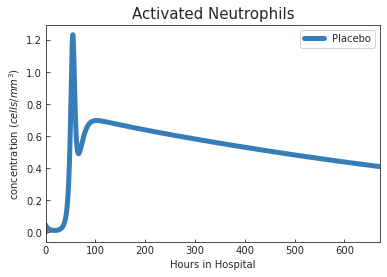

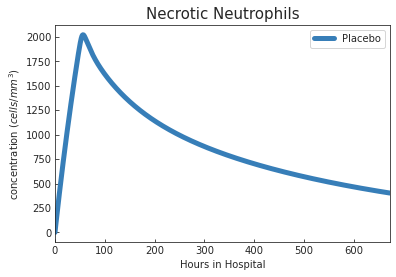

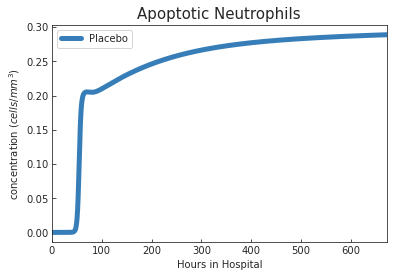

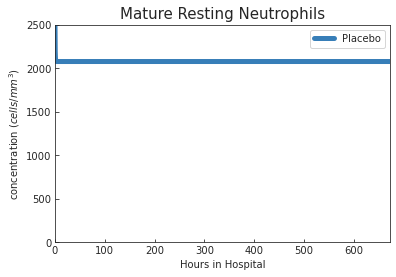

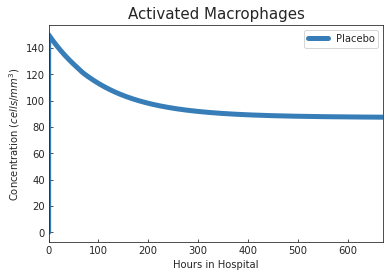

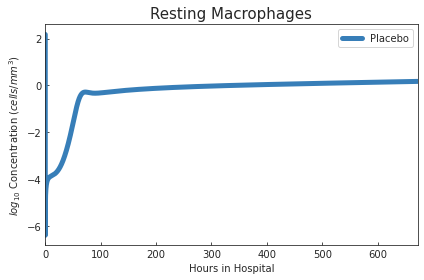

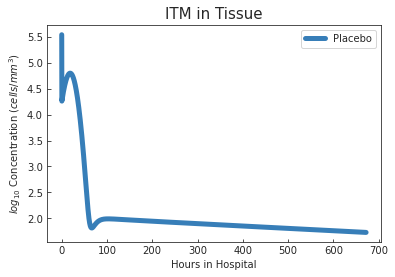

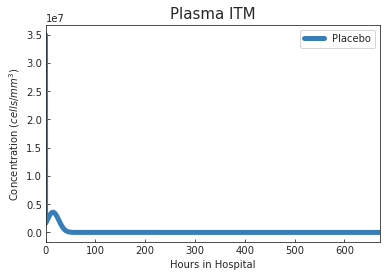

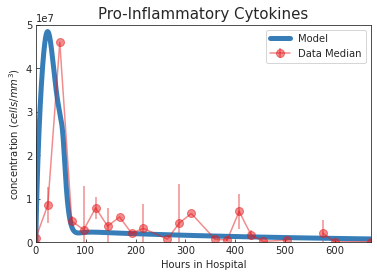

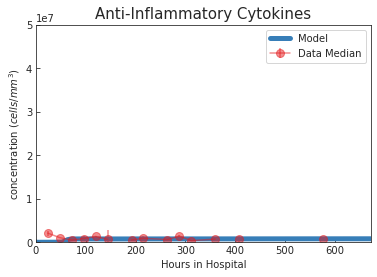

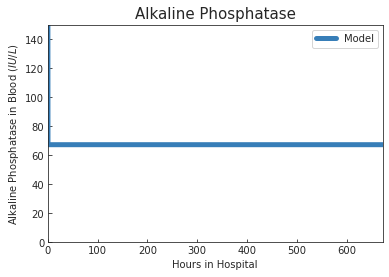

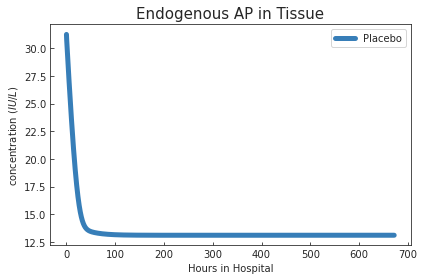

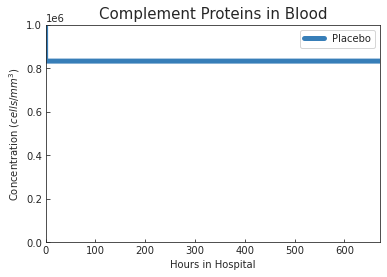

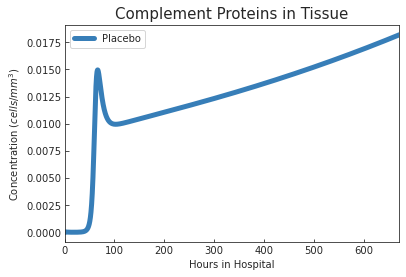

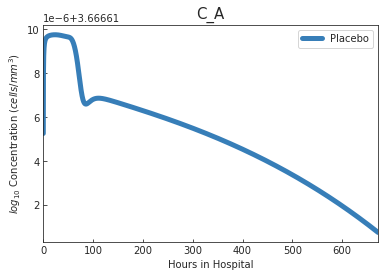

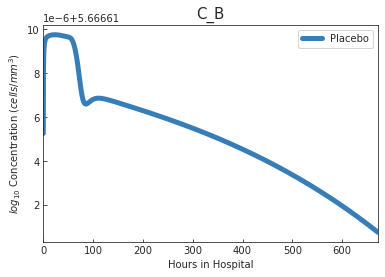

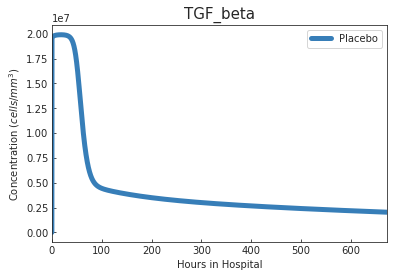

In [18]:
plot_params = {
    'lw': 5,
    'ls': 10,
    'fs': 10,
    'lfs': 10,
    'ts': 15,
    'ms': 8,
    'title': 'Hours in Hospital',
    'timeout':  'hours',
    'case_label': case_names[params['case']-1]
}

for case in cases:
    print('Processing Case :', case, ' (', case_names[case-1], ')')

    p = [mu_ACH, mu_APE, mu_APS, mu_APSfast, mu_APSslow, mu_CH, mu_MA, mu_MR, mu_NA, mu_NDA, mu_NDN,
         mu_NR, mu_ITM, Pmin_MR, Pmin_NR, ACHmax, CHmax_tissue, Mmax, Nmax, Pmax_MR, Pmax_NR, Keq_CH, phi_MRA,
         theta_ACH, lamb_APE, lamb_ITMNA, lamb_ITMMA, lamb_MANDA, lamb_MANDN, lamb_APS, alpha_ACHMA, beta_CHMA,
         beta_CHNA, beta_MANDA, APEmax, APEbmax_, APElmax_, APSmax_, rdistress, lamb_ITMNDN, alpha_ITMNDN, Pmax_APE,
         Pmin_APE, rinduce_peak, AP_Sinj, w_gauss_min, r_Nhomeo, r_APhomeo, Pmax_ITM, Pmin_ITM, ITMmax, step_max,
         r_NDN, r_ITM, r_ITMpeak, r_AP, rinduce, ITM_source_peak, ITM_source_width, mu_C, mu_TFGbeta,
         alpha_CAMA, alpha_CBMA, alpha_TFGbetaMA, TGF_betamax, Keq_CHC, Cmax, Pmax_C, Pmin_C, r_Chomeo, C_bloodmax, r_c, C_lambmin, theta_TGFbeta]

    w = [N_R0,
         AP_Eblood0,
         AP_Etissue0,
         AP_Eliver0,
         AP_Sblood0,
         AP_St0, ITMblood0, ITMtissue0,
         M_R0, M_A0, CH0, N_A0, ND_A0, ACH0, ND_N0, C_blood0, C0, C_A0, C_B0, TGF_beta0]

    params['case'] = case
    w0 = get_init(w, params)

    t, wsol = solve(p, w0, t, params)
    df_model, t_list = prep_plot(wsol, t_interval=t, timein=time, timeout=plot_params['timeout'])
    plot(df_model, plot_params, df_IL6, df_IL10, t_list)
#     plot(wsol, case_names, timein=time, time_interval=t, df_IL6, df_IL10, params, df_model)

In [19]:
mw = 190 * 10 ** 3

mult = ((6.02 * 10 ** 23) / (mw * 10 ** 6))

In [20]:
mult * 1.6

5069473684210.526

In [21]:
mw = 240 * 10 ** 3

mult = ((1 * 10 ** -9) * (6.02 * 10 ** 23) / ((1 * 10 ** -3) * mw * 10 ** 6))

In [22]:
mult * 25

62708333.333333336